## Welcome back to Python Notebooks!

Didja miss me??

### And welcome to Week 4, Day 2 - introducing LangGraph!

In [1]:
from typing import Annotated
from langgraph.graph import StateGraph, START, END
from langgraph.graph.message import add_messages
from dotenv import load_dotenv
from IPython.display import Image, display
import gradio as gr
from langchain_openai import ChatOpenAI
from pydantic import BaseModel
import random
import os
from openai import AsyncOpenAI
from agents import OpenAIChatCompletionsModel


In [2]:
# Some useful constants

nouns = ["Cabbages", "Unicorns", "Toasters", "Penguins", "Bananas", "Zombies", "Rainbows", "Eels", "Pickles", "Muffins"]
adjectives = ["outrageous", "smelly", "pedantic", "existential", "moody", "sparkly", "untrustworthy", "sarcastic", "squishy", "haunted"]

In [2]:
# Our favorite first step! Crew was doing this for us, by the way.
load_dotenv(override=True)

True

In [4]:
def shout(text: Annotated[str, "something to be shouted"]) -> str:
    print(text.upper())
    print()
    return text.upper()

shout("hello")

HELLO



'HELLO'

In [5]:
def shout(text: str) ->str:
    print(text.upper())
    return text.upper()

shout("Hello")

HELLO


'HELLO'

### A word about "Annotated"

You probably know this; type hinting is a feature in Python that lets you specify the type of something:

`my_favorite_things: List`

But you may not know this:

You can also use something called "Annotated" to add extra information that somebody else might find useful:

`my_favorite_things: Annotated[List, "these are a few of mine"]`

LangGraph needs us to use this feature when we define our State object.

It wants us to tell it what function it should call to update the State with a new value.

This function is called a **reducer**.

LangGraph provides a default reducer called `add_messages` which takes care of the most common case.

And that hopefully explains why the State looks like this.




### Step 1: Define the State object

You can use any python object; but it's most common to use a TypedDict or a Pydantic BaseModel.

In [6]:
# this class state is subclass of basemodel from pydantic, which is a particular type of dictionary in python 
class State(BaseModel):
    messages: Annotated[list, add_messages]
    # here the add_messages are reducers that are used for indicating to langgraph what is a thing for
    # add_messages is imported from langgraph.graph.messages
    # ad_messages is an anotation where we can define reducers, reducer is where we define the function that will be called inorder to combine one state with another 


### Step 2: Start the Graph Builder with this State class

In [ ]:
graph_builder = StateGraph(State)
# here state is not an object, but a class, type of thing that we call our state

### Step 3: Create a Node

A node can be any python function.

The reducer that we set before gets automatically called to combine this response with previous responses


In [ ]:
def our_first_node(old_state: State) -> State:

    reply = f"{random.choice(nouns)} are {random.choice(adjectives)}"
    messages = [{"role": "assistant", "content": reply}]

    new_state = State(messages=messages)

    return new_state

graph_builder.add_node("first_node", our_first_node)

### Step 4: Create Edges

In [ ]:
graph_builder.add_edge(START, "first_node")
graph_builder.add_edge("first_node", END)

### Step 5: Compile the Graph

In [ ]:
graph = graph_builder.compile()

In [ ]:
display(Image(graph.get_graph().draw_mermaid_png()))

### That's it! Showtime!

In [ ]:
def chat(user_input: str, history):
    message = {"role": "user", "content": user_input}
    messages = [message]
    state = State(messages=messages)
    result = graph.invoke(state)
    print(result)
    return result["messages"][-1].content


gr.ChatInterface(chat, type="messages").launch()

### But why did I show you that?

To make the point that LangGraph is all about python functions - it doesn't need to involve LLMs!!

Now we'll do the 5 steps again, but in 1 shot:

In [ ]:
# Step 1: Define the State object
class State(BaseModel):
    messages: Annotated[list, add_messages]


In [ ]:
# Step 2: Start the Graph Builder with this State class
graph_builder = StateGraph(State)


In [ ]:
google_api_key = os.getenv('GOOGLE_API_KEY')
GEMINI_BASE_URL = "https://generativelanguage.googleapis.com/v1beta/openai/"
gemini_client = AsyncOpenAI(base_url=GEMINI_BASE_URL, api_key=google_api_key)
gemini_model = OpenAIChatCompletionsModel(model="gemini-2.0-flash", openai_client=gemini_client)

llm = ChatOpenAI(model=gemini_model)

In [ ]:
# Step 3: Create a Node

# llm = ChatOpenAI(model="gpt-4o-mini")

def chatbot_node(old_state: State) -> State:
    response = llm.invoke(old_state.messages)
    new_state = State(messages=[response])
    return new_state

graph_builder.add_node("chatbot", chatbot_node)

In [ ]:
# Step 4: Create Edges
graph_builder.add_edge(START, "chatbot")
graph_builder.add_edge("chatbot", END)

In [ ]:
# Step 5: Compile the Graph
graph = graph_builder.compile()
display(Image(graph.get_graph().draw_mermaid_png()))

### That's it! And, let's do this:

In [ ]:
def chat(user_input: str, history):
    initial_state = State(messages=[{"role": "user", "content": user_input}])
    result = graph.invoke(initial_state)
    print(result)
    return result['messages'][-1].content


gr.ChatInterface(chat, type="messages").launch()

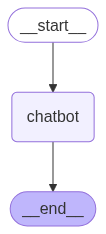

* Running on local URL:  http://127.0.0.1:7868
* To create a public link, set `share=True` in `launch()`.


{'messages': [HumanMessage(content='hi', additional_kwargs={}, response_metadata={}, id='b327bbc1-2d76-47d1-9001-71613e0b1f94'), AIMessage(content='Hi there! How can I help you today?', additional_kwargs={}, response_metadata={'prompt_feedback': {'block_reason': 0, 'safety_ratings': []}, 'finish_reason': 'STOP', 'model_name': 'gemini-2.0-flash', 'safety_ratings': []}, id='run--619777ce-a97d-4f67-abbf-817e157b92a8-0', usage_metadata={'input_tokens': 1, 'output_tokens': 11, 'total_tokens': 12, 'input_token_details': {'cache_read': 0}})]}
{'messages': [HumanMessage(content='hi', additional_kwargs={'metadata': None, 'options': None}, response_metadata={}, id='8f8c2256-ac04-47b7-ac5e-830ec5f1a13d'), AIMessage(content='Hi there! How can I help you today?', additional_kwargs={'metadata': None, 'options': None}, response_metadata={}, id='fae0be5d-a075-4c12-b216-7c4b71ff4575'), HumanMessage(content='2+2?', additional_kwargs={}, response_metadata={}, id='18b8c3d4-5547-430b-99a0-dc8ed7c4fa4e'), A

In [3]:
from typing import Annotated
import os
from pydantic import BaseModel
from IPython.display import display, Image
from dotenv import load_dotenv
from langgraph.graph import StateGraph, START, END
from langgraph.graph.message import add_messages
import gradio as gr
from langchain_google_genai import ChatGoogleGenerativeAI

load_dotenv(override=True)
google_api_key = os.getenv('GOOGLE_API_KEY')

class State(BaseModel):
    messages: Annotated[list, add_messages]

graph_builder = StateGraph(State)

llm = ChatGoogleGenerativeAI(model="gemini-2.0-flash", google_api_key=google_api_key)

def chatbot_node(old_state: State) -> State:
    # Invoke the LLM with the current messages
    # sends [HumanMessage(content="hi")] to the Gemini model.
    reply = llm.invoke(old_state.messages)  # Returns AIMessage
    
    # Append the reply to the existing messages using add_messages
    new_messages = old_state.messages + [reply]
    
    # here, add_messages ensures the HumanMessage and AIMessage are appended correctly.
    # this returns dictionary containing "messages" array
    new_state = State(messages=new_messages)
    return new_state

# Add the node and edges
graph_builder.add_node("chatbot", chatbot_node)
graph_builder.add_edge(START, "chatbot")
graph_builder.add_edge("chatbot", END)

# Compile the graph
graph = graph_builder.compile()

# Visualize the graph
display(Image(graph.get_graph().draw_mermaid_png()))

# Define the chat function to handle Gradio input and history
def chat(user_input: str, history: list):
    # Use history directly; if empty, include the user_input
    messages = history or [{"role": "user", "content": user_input}]
    
    # If history is not empty, ensure the last user input isn't duplicated
    if history and history[-1]["role"] == "user" and history[-1]["content"] == user_input:
        messages = history
    else:
        messages = history + [{"role": "user", "content": user_input}]
    
    # Create the State object
    # the State class processes the message using add_messages
    # add_message converts the dictionary messages to a HumanMessage object
    state = State(messages=messages)

    # Invoke the graph
    # this graph will run the chatbot_node
    result = graph.invoke(state)
    print(result)
    # Return the latest assistant message for Gradio
    return result['messages'][-1].content

# Launch the Gradio interface
gr.ChatInterface(chat, type="messages").launch()




#--------------------------
# add_message is invoked when State object is created (State(messages=messages)) or updated (new_state = State(messages=new_messages))
# add_message functionality:
#    converts the input dictionaries to HumanMessage objects
#    appends the AIMessage objects from LLM to the messages list
#    it ensures the list maintains the order, (user → assistant → user → assistant)
#--------------------------